In [21]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 不加这几句，则CONV 报错
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [22]:
data = pd.read_csv("./data/data_1009.csv", header=0,infer_datetime_format=True, engine='python')
data['Unnamed: 0']=pd.to_datetime(data['Unnamed: 0'])
data.set_index("Unnamed: 0",inplace=True)

In [23]:
'''
归一化
'''
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler3 = MinMaxScaler(feature_range=(0, 1))
scaler4 = MinMaxScaler(feature_range=(0, 1))
scaler5 = MinMaxScaler(feature_range=(0, 1))
scaler6 = MinMaxScaler(feature_range=(0, 1))
scaler7 = MinMaxScaler(feature_range=(0, 1))
scaler8 = MinMaxScaler(feature_range=(0, 1))
data_minmax = data.copy()
data_minmax['pm2.5']=scaler1.fit_transform(data_minmax['pm2.5'].values.reshape(-1,1))
data_minmax['DEWP']=scaler2.fit_transform(data_minmax['DEWP'].values.reshape(-1,1))
data_minmax['TEMP']=scaler3.fit_transform(data_minmax['TEMP'].values.reshape(-1,1))
data_minmax['PRES']=scaler4.fit_transform(data_minmax['PRES'].values.reshape(-1,1))
data_minmax['cbwd_NE']=scaler5.fit_transform(data_minmax['cbwd_NE'].values.reshape(-1,1))
data_minmax['cbwd_NW']=scaler6.fit_transform(data_minmax['cbwd_NW'].values.reshape(-1,1))
data_minmax['cbwd_SE']=scaler7.fit_transform(data_minmax['cbwd_SE'].values.reshape(-1,1))
data_minmax['cbwd_cv']=scaler7.fit_transform(data_minmax['cbwd_cv'].values.reshape(-1,1))

In [24]:
'''
取一年的时间，10个月做训练和验证，2个月做测试
'''
cast1 = 35064
cast2 = -1464
data_train = data_minmax[cast1:cast2]
data_test = data_minmax[cast2:] 
data_train.shape,data_test.shape

((7296, 8), (1464, 8))

In [25]:
data_train = np.array(data_train)
data_test = np.array(data_test)
data_train.shape,data_test.shape

((7296, 8), (1464, 8))

In [26]:
from utils.data_split import split_sequence_parallel

In [27]:
sw_width = 21
pred_length = 12
verbose_set = 2
X, y, features = split_sequence_parallel(data_train,sw_width,pred_length)
test_x,test_y,test_features = split_sequence_parallel(data_test,sw_width,pred_length)

In [28]:
def LSTM_model():
#     ip = Input(shape=(MAX_NB_VARIABLES, MAX_TIMESTEPS))
    ip = Input(shape=(sw_width,features))

    x = LSTM(100,activation='relu')(ip)
#     x = BatchNormalization()(x)
    x = Dropout(0.8)(x)

    
    out = Dense(pred_length)(x)

    model = Model(ip, out)
    model.summary()


    return model

In [29]:
LSTM_model1 = LSTM_model()
LSTM_model1

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21, 8)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               43600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1212      
Total params: 44,812
Trainable params: 44,812
Non-trainable params: 0
_________________________________________________________________


In [10]:
import time
from keras import backend as K
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
# from utils.lr_process import lr_schedule
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# lr_scheduler = LearningRateScheduler(lr_schedule)
# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

filepath = "D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\\12hourweights\LSTM_model_weights_best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
callbacks_list = [checkpoint]

In [11]:
starttime=time.time()
LSTM_model1.compile(loss=root_mean_squared_error, optimizer='adam')
history1 = LSTM_model1.fit(X,y,validation_split=0.33,epochs=100, batch_size=32,callbacks=callbacks_list, verbose=2)
endtime=time.time()
dtime=endtime-starttime
print("程序运行时间为：%.8s s" % dtime)  #时间显示到微秒

Train on 4866 samples, validate on 2398 samples
Epoch 1/100
 - 4s - loss: 0.0998 - val_loss: 0.0546

Epoch 00001: val_loss improved from inf to 0.05464, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\LSTM_model_weights_best.hdf5
Epoch 2/100
 - 3s - loss: 0.0762 - val_loss: 0.0521

Epoch 00002: val_loss improved from 0.05464 to 0.05215, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\LSTM_model_weights_best.hdf5
Epoch 3/100
 - 3s - loss: 0.0724 - val_loss: 0.0510

Epoch 00003: val_loss improved from 0.05215 to 0.05096, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\LSTM_model_weights_best.hdf5
Epoch 4/100
 - 3s - loss: 0.0690 - val_loss: 0.0462

Epoch 00004: val_loss improved from 0.05096 to 0.04623, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\LSTM_model_weights_best.hdf5
Epoch 5/100
 - 3s - loss: 0.0695 - val_loss: 0.0476

Epoch 00005: val_loss did not improve from 0.04623
Epoch 6/100
 - 3s - loss: 0.0676 - val_loss: 0.0451

Epo

 - 4s - loss: 0.0584 - val_loss: 0.0425

Epoch 00066: val_loss did not improve from 0.04164
Epoch 67/100
 - 4s - loss: 0.0587 - val_loss: 0.0432

Epoch 00067: val_loss did not improve from 0.04164
Epoch 68/100
 - 4s - loss: 0.0562 - val_loss: 0.0448

Epoch 00068: val_loss did not improve from 0.04164
Epoch 69/100
 - 4s - loss: 0.0562 - val_loss: 0.0429

Epoch 00069: val_loss did not improve from 0.04164
Epoch 70/100
 - 4s - loss: 0.0577 - val_loss: 0.0435

Epoch 00070: val_loss did not improve from 0.04164
Epoch 71/100
 - 4s - loss: 0.0573 - val_loss: 0.0442

Epoch 00071: val_loss did not improve from 0.04164
Epoch 72/100
 - 4s - loss: 0.0576 - val_loss: 0.0425

Epoch 00072: val_loss did not improve from 0.04164
Epoch 73/100
 - 4s - loss: 0.0572 - val_loss: 0.0440

Epoch 00073: val_loss did not improve from 0.04164
Epoch 74/100
 - 4s - loss: 0.0567 - val_loss: 0.0436

Epoch 00074: val_loss did not improve from 0.04164
Epoch 75/100
 - 4s - loss: 0.0575 - val_loss: 0.0432

Epoch 00075: v

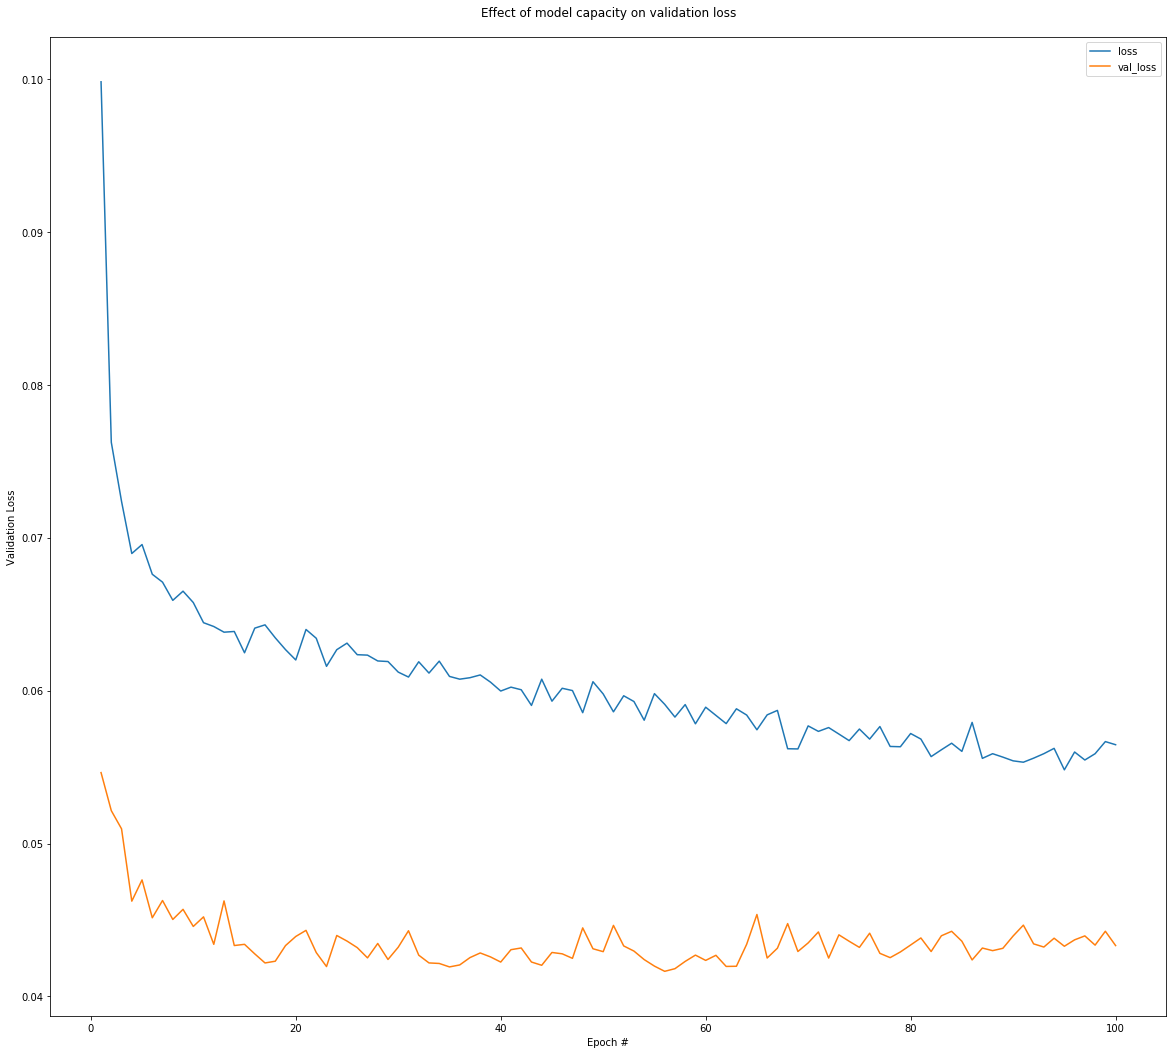

In [12]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = np.arange(100) + 1
plt.figure(figsize=(20,18))
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [13]:
LSTM_model1.load_weights(filepath)

In [14]:
predict=LSTM_model1.predict(test_x)
predict=scaler1.inverse_transform(predict.reshape(predict.shape[0],predict.shape[1]))

In [15]:
predict.shape,test_y.shape

((1432, 12), (1432, 12))

In [16]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y))).numpy().mean()

55.995033897924

In [30]:
filepath = "D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\\12hourweights\LSTM_model_weights_best.hdf5"
LSTM_model1.load_weights(filepath)

In [31]:
predict=LSTM_model1.predict(test_x)
predict=scaler1.inverse_transform(predict.reshape(predict.shape[0],predict.shape[1]))

In [32]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y))).numpy().mean()

55.995033897924

In [33]:
tf.losses.mae(predict,scaler1.inverse_transform(test_y)).numpy().mean()

49.88531981231004

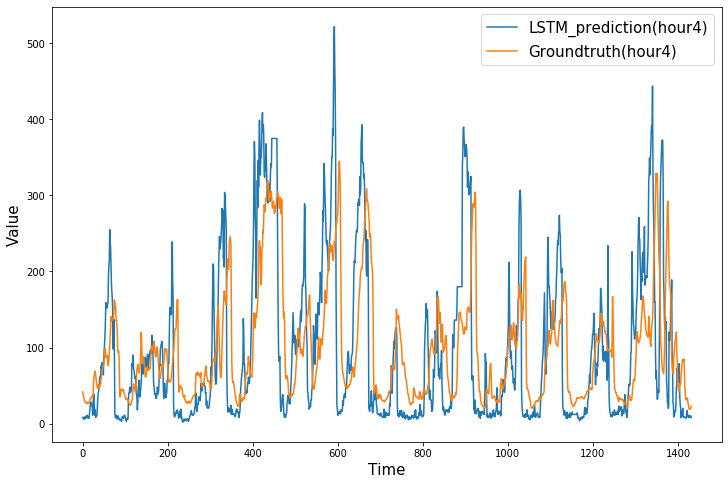

In [34]:
plt.figure(figsize=(12,8))
plt.plot(scaler1.inverse_transform(test_y)[:,10],label='LSTM_prediction(hour4)')
plt.plot(predict[:,10],label='Groundtruth(hour4)')
plt.xlabel('test dataset(11/01/2014-12/31/2014)')
plt.ylabel('PM2.5 value')
plt.ylabel('Value',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.legend(loc="upper right",fontsize=15)
plt.show()

# 每小时细粒度

In [37]:
tf.sqrt(tf.losses.mean_squared_error(predict[:,:6],scaler1.inverse_transform(test_y)[:,:6])).numpy().mean()

43.080189520325696

In [45]:
tf.losses.mae(predict[:,:6],scaler1.inverse_transform(test_y)[:,:6]).numpy().mean()

39.25706906397471

In [44]:
tf.sqrt(tf.losses.mean_squared_error(predict[:,6:],scaler1.inverse_transform(test_y)[:,6:])).numpy().mean()

63.63282317048879

In [46]:
tf.losses.mae(predict[:,6:],scaler1.inverse_transform(test_y)[:,6:]).numpy().mean()

60.513570560645356

In [43]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mean_squared_error(predict[:,i],scaler1.inverse_transform(test_y)[:,i])).numpy()
    print(i,":",loss1)

0 : 31.011970276352766
1 : 42.63914936844203
2 : 52.75018236942968
3 : 61.105941218449004
4 : 68.01759301224449
5 : 73.93102793472787
6 : 79.14699340496675


In [44]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mae(predict[:,i],scaler1.inverse_transform(test_y)[:,i])).numpy()
    print(i,":",loss1)

0 : 4.5751317959921485
1 : 5.175111901118496
2 : 5.701865689694472
3 : 6.166021406070984
4 : 6.571699621399015
5 : 6.898115435863145
6 : 7.210252158830201


In [35]:
predict.shape

(1432, 12)